# Day 8 - Lab 1: Vision-Enabled UI/UX Agents

**Objective:** Use multi-modal vision models to generate a frontend UI from a design image, and then use a second agent to perform an automated design review.

**Estimated Time:** 90 minutes

**Introduction:**
Welcome to Day 8! Today, we'll explore one of the most exciting advancements in AI: vision. We will use a vision-capable model to act as a frontend developer, translating a design image directly into code. Then, we will create a second "UI/UX Critic" agent to automate the design review process, demonstrating a complete, AI-assisted frontend workflow.

For definitions of key terms used in this lab, please refer to the [GLOSSARY.md](../../GLOSSARY.md).

## Step 1: Setup

For this lab, we need to ensure we are using a vision-capable model. We will configure our `utils.py` helper to use a model like OpenAI's `gpt-4o` or Google's `gemini-2.5-pro`.

**Model Selection:**
This lab requires a vision-capable model. Excellent choices include `gpt-4o`, `gemini-2.5-pro`, or `deepseek-ai/DeepSeek-VL2`.

**Helper Functions Used:**
- `setup_llm_client()`: To configure the API client.
- `get_vision_completion()`: A specialized function to send an image and a text prompt to a vision model.
- `get_completion()`: To send text-only prompts for the refactoring step.
- `save_artifact()`: To save the generated code and the design review.

In [135]:
import sys
import os

# Add the project's root directory to the Python path
try:
    project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
except IndexError:
    project_root = os.path.abspath(os.path.join(os.getcwd()))

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from utils import setup_llm_client, get_vision_completion, get_image_generation_completion, get_completion, save_artifact, clean_llm_output, recommended_models_table, load_artifact, get_image_edit_completion
from IPython.display import Image, display, Code

image_client, image_model_name, image_api_provider = setup_llm_client(model_name="gemini-2.5-flash-image-preview")
print(f"✅ Using {image_model_name} for image generation")

# Ensure you select a vision-capable model
vision_client, vision_model_name, vision_api_provider = setup_llm_client(model_name="gpt-4o")
print(f"✅ Using {vision_model_name} for vision tasks")

# use vision client for text client as well
client, model_name, api_provider = vision_client, vision_model_name, vision_api_provider


if not image_model_name or not vision_model_name:
    print("Could not set up a valid LLM client. Please check your .env file and utils.py configuration.")

2025-11-03 13:54:55,321 ag_aisoftdev.utils INFO LLM Client configured provider=google model=gemini-2.5-flash-image-preview latency_ms=None artifacts_path=None


✅ Using gemini-2.5-flash-image-preview for image generation


2025-11-03 13:54:55,646 ag_aisoftdev.utils INFO LLM Client configured provider=openai model=gpt-4o latency_ms=None artifacts_path=None


✅ Using gpt-4o for vision tasks


In [136]:
recommended_models_table()

| Model | Provider | Text | Vision | Image Gen | Image Edit | Audio Transcription | Context Window | Max Output Tokens |
|---|---|---|---|---|---|---|---|---|
| MiniMaxAI/MiniMax-M2 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 128,000 | 8,192 |
| Qwen/Qwen-Image | huggingface | ❌ | ❌ | ✅ | ❌ | ❌ | - | - |
| Qwen/Qwen-Image-Edit | huggingface | ❌ | ❌ | ❌ | ✅ | ❌ | - | - |
| black-forest-labs/FLUX.1-Kontext-dev | huggingface | ❌ | ❌ | ❌ | ✅ | ❌ | - | - |
| claude-haiku-4-5-20251001 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 64,000 |
| claude-opus-4-1-20250805 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 32,000 |
| claude-sonnet-4-5-20250929 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 64,000 |
| dall-e-3 | openai | ❌ | ❌ | ✅ | ❌ | ❌ | - | - |
| deepseek-ai/DeepSeek-V3.1 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 128,000 | 100,000 |
| gemini-1.5-flash | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 8,192 |
| gemini-1.5-pro | google | ✅ | ✅ | ❌ | ❌ | ❌ | 2,000,000 | 8,192 |
| gemini-2.0-flash-exp | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 8,192 |
| gemini-2.0-flash-preview-image-generation | google | ❌ | ❌ | ✅ | ✅ | ❌ | 32,000 | 8,192 |
| gemini-2.5-flash | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 65,536 |
| gemini-2.5-flash-image-preview | google | ❌ | ❌ | ✅ | ✅ | ❌ | 32,768 | 32,768 |
| gemini-2.5-flash-lite | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 65,536 |
| gemini-2.5-pro | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 65,536 |
| gemini-live-2.5-flash-preview | google | ❌ | ❌ | ❌ | ❌ | ❌ | 1,048,576 | 8,192 |
| gpt-4.1 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 32,768 |
| gpt-4.1-mini | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 32,000 |
| gpt-4.1-nano | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 32,000 |
| gpt-4o | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 128,000 | 16,384 |
| gpt-4o-mini | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 128,000 | 16,384 |
| gpt-4o-mini-transcribe | openai | ❌ | ❌ | ❌ | ❌ | ✅ | - | - |
| gpt-4o-transcribe | openai | ❌ | ❌ | ❌ | ❌ | ✅ | - | - |
| gpt-5-2025-08-07 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 400,000 | 128,000 |
| gpt-5-mini-2025-08-07 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 400,000 | 128,000 |
| gpt-5-nano-2025-08-07 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 400,000 | 128,000 |
| meta-llama/Llama-3.3-70B-Instruct | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 8,192 | 4,096 |
| meta-llama/Llama-4-Maverick-17B-128E-Instruct | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 1,000,000 | 100,000 |
| meta-llama/Llama-4-Scout-17B-16E-Instruct | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 10,000,000 | 100,000 |
| mistralai/Mistral-7B-Instruct-v0.3 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 32,768 | 8,192 |
| o3 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 100,000 |
| o4-mini | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 100,000 |
| stabilityai/stable-diffusion-3.5-large | huggingface | ❌ | ❌ | ✅ | ❌ | ❌ | - | - |
| tokyotech-llm/Llama-3.1-Swallow-8B-Instruct-v0.5 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 4,096 | 1,024 |
| veo-3.1-fast-generate-preview | google | ❌ | ❌ | ❌ | ❌ | ❌ | 1,024 | - |
| veo-3.1-generate-preview | google | ❌ | ❌ | ❌ | ❌ | ❌ | 1,024 | - |
| whisper-1 | openai | ❌ | ❌ | ❌ | ❌ | ✅ | - | - |

'| Model | Provider | Text | Vision | Image Gen | Image Edit | Audio Transcription | Context Window | Max Output Tokens |\n|---|---|---|---|---|---|---|---|---|\n| MiniMaxAI/MiniMax-M2 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 128,000 | 8,192 |\n| Qwen/Qwen-Image | huggingface | ❌ | ❌ | ✅ | ❌ | ❌ | - | - |\n| Qwen/Qwen-Image-Edit | huggingface | ❌ | ❌ | ❌ | ✅ | ❌ | - | - |\n| black-forest-labs/FLUX.1-Kontext-dev | huggingface | ❌ | ❌ | ❌ | ✅ | ❌ | - | - |\n| claude-haiku-4-5-20251001 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 64,000 |\n| claude-opus-4-1-20250805 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 32,000 |\n| claude-sonnet-4-5-20250929 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 64,000 |\n| dall-e-3 | openai | ❌ | ❌ | ✅ | ❌ | ❌ | - | - |\n| deepseek-ai/DeepSeek-V3.1 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 128,000 | 100,000 |\n| gemini-1.5-flash | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 8,192 |\n| gemini-1.5-pro | google | ✅ | ✅ | ❌ | ❌ | ❌ | 2,000,000 | 8,192 |\n| gemini-2.0-flash-exp 

## Step 2: The Design Screenshot

This is the design we want our AI agent to build. It's a simple login form component. We will provide the URL to this image directly to the model.

In [137]:
# for step 2:
# Use LLMs/agents to describe your screen(s) providing the proper context
# Use image generation models to produce screen designer
# Use image editing models to refine your designs

prd_document = load_artifact("day1_prd_2025-10-28_14-03-52.md")

screen_description_prompt = f"""
Describe a modern onboarding tool homepage screen with a clean layout, with a left sidebar navigation, a welcome message in the center, and a call-to-action button. Ensure that the page has a top menu bar with the site title, logo, and user profile icon. Provide details on color scheme, typography, and imagery to be used. The middle section should contain different widgets of the tool, such as user progress, input forms, tips, and resources.

Base the description off of the product requirement document below:
Product Requirement Document:
{prd_document}

Do not include any code or image generation prompts, only provide a detailed textual description of the screen design.
Do not mention the functionality of the tool or screen, only focus on the visual and UI/UX aspects. 
Make sure screen description accounts for accessibility best practices.
"""

screen_description = get_completion(screen_description_prompt, vision_client, vision_model_name, vision_api_provider)
print("--- Screen Description ---")
print(screen_description)


--- Screen Description ---
The Ascend Onboarding Platform homepage screen is designed with a focus on clarity, modern aesthetics, and usability, ensuring a welcoming experience for new users. 

**Color Scheme:**
The page employs a calming and professional color palette. The background is a soft, neutral gray to reduce eye strain, allowing the content to stand out. Accent colors include a refreshing teal for interactive elements like buttons and highlights, and a deeper blue for the sidebar and top menu bar, providing a sense of stability and trust.

**Typography:**
The typography is clean and accessible, featuring a sans-serif typeface such as "Roboto" or "Open Sans" for its legibility and modern appeal. Headers are bold and slightly larger in size to guide the user’s attention, while body text is medium-weight, ensuring readability. All text adheres to WCAG 2.1 AA standards, with sufficient contrast against the background.

**Layout:**

- **Top Menu Bar:**
  Positioned at the top is a

Using gemini-2.5-flash-image-preview for image generation...
✅ Generated image saved to: C:\Users\labadmin\Desktop\Workspace\AG-AISOFTDEV\artifacts\screens\image_1762196121.png



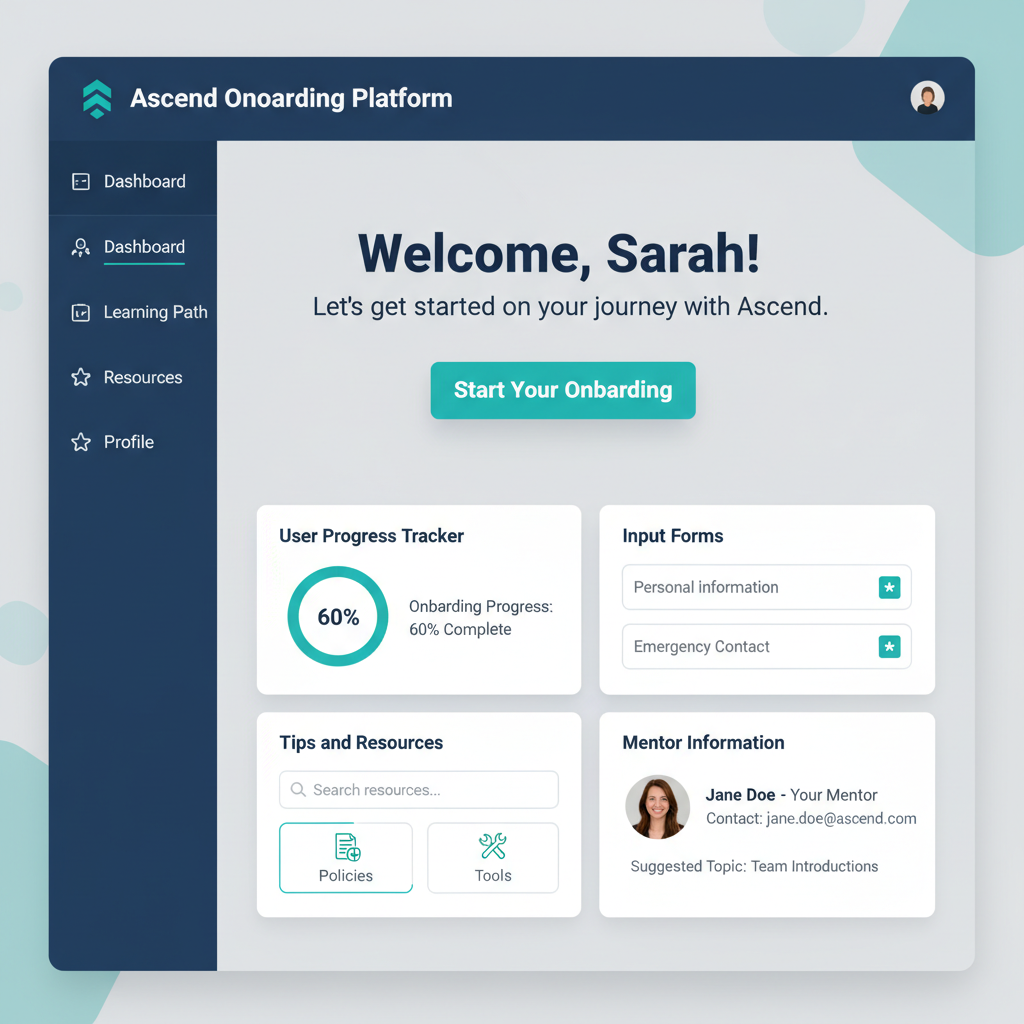

In [138]:
screen_generation_prompt = f"""
Generate an image of an onboarding tool homepage screen with modern UI design, clean layout, and following accessibility best practices.

Follow these design details exactly:
{screen_description}

Avoid childish or cartoonish styles. Use a professional and sleek design aesthetic suitable for a business application.
Focus on clarity, usability, and visual appeal.
**Output should only be the screen/UI design and nothing else. Do NOT include any additional elements, borders, or annotations outside of the screen design itself.**
**Ensure sidebar navigation is visible on the left and does not overflow outside the screen boundaries.**
"""

print(f"Using {image_model_name} for image generation...")
file_path, image_url = get_image_generation_completion(screen_generation_prompt, image_client, image_model_name, image_api_provider)

# Display the generated image if successful
if file_path and image_url:
    print(f"✅ Generated image saved to: {file_path}")
    display(Image(url=image_url))
elif image_url:
    print(f"❌ Image generation failed: {image_url}")
else:
    print("❌ Image generation returned no result")

✅ Edited image saved to: C:\Users\labadmin\Desktop\Workspace\AG-AISOFTDEV\artifacts\screens\image_1762196133.png



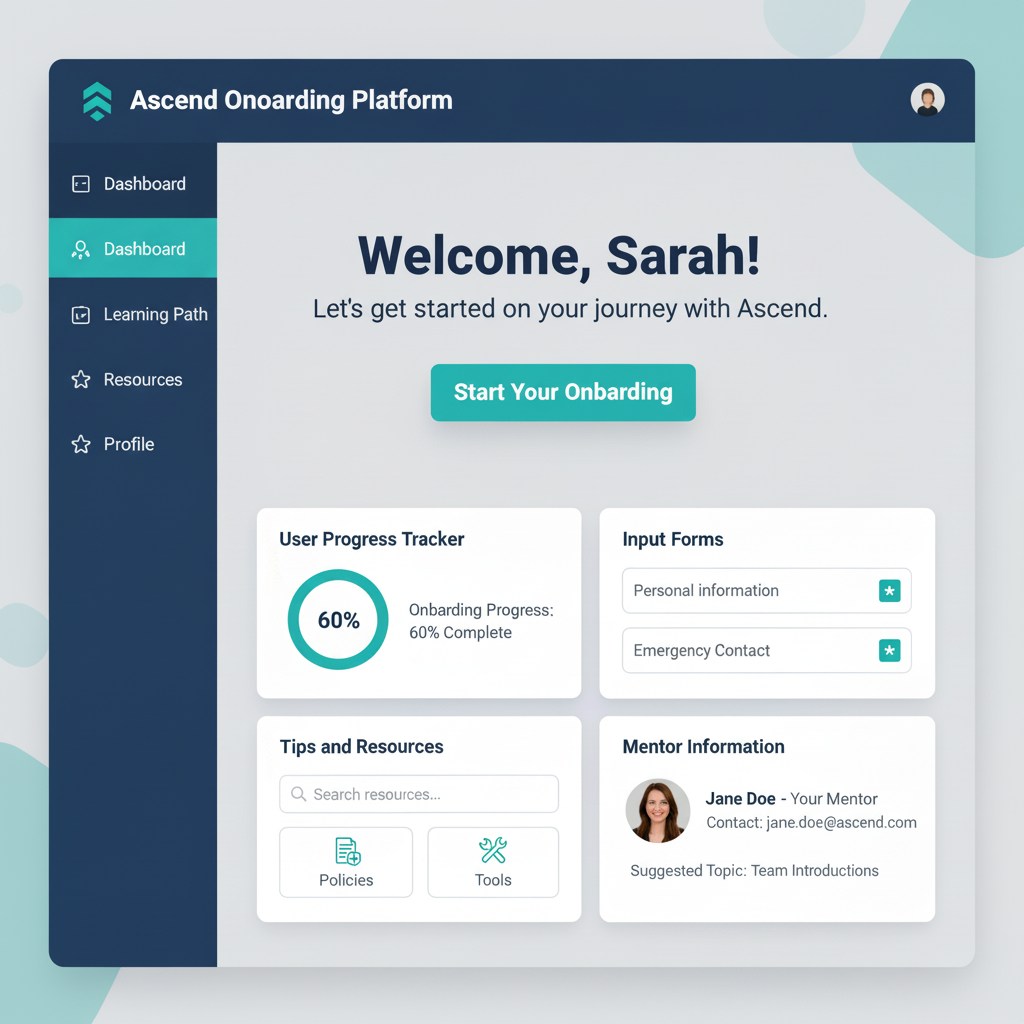

In [139]:
# Use image editing models to refine your designs
image_edit_prompt = f"""
You are a senior product UI/UX designer.

Improve this onboarding dashboard mockup while preserving its core layout (left sidebar nav, top bar, central widgets).

Enhance:
- Visual hierarchy (clear section grouping, spacing rhythm 8/12/16px multiples where logical)
- Accessibility (contrast >= WCAG AA, legible font sizes, clear focus affordances)
- Sidebar clarity (active item state, subtle hover)
- Consistent icon + label alignment
- Refine call-to-action prominence (primary button)
- Harmonize color palette (professional, modern, neutral with one accent)
- Subtle depth (soft shadows, layered panels) without clutter
- Remove any visual noise or artifacts

Do NOT:
- Change overall information architecture
- Add unrealistic glossy effects
- Add text outside the UI frame
- Repeat or duplicate elements

Return ONLY the refined screen image—no borders, watermarks, captions, or extra whitespace.
"""

try:
    edited_file_path, edited_image_url = get_image_edit_completion(
        image_edit_prompt,
        file_path,              
        image_client,
        image_model_name,
        image_api_provider
    )

    if edited_file_path and edited_image_url:
        print(f"✅ Edited image saved to: {edited_file_path}")
        display(Image(url=edited_image_url))
    else:
        print("❌ Image edit failed or returned no result.")
except Exception as e:
    print(f"⚠️ Image editing encountered an error: {e}")


## Step 3: The Challenges

### Challenge 1 (Foundational): Generating a Monolithic UI Component

**Task:** Use the vision model to generate a single, self-contained React component that replicates the design from the image.

> **Tip for Vision Prompts:** Be specific about the output format. Telling the model you want 'React' and 'Tailwind CSS' is crucial. The more specific your technical constraints, the better the generated code will be.

**Instructions:**
1.  Create a prompt that asks the vision model to act as an expert frontend developer.
2.  The prompt should instruct the model to analyze the image at the provided URL.
3.  Ask it to generate a single React component using Tailwind CSS for styling.
4.  The output should be a single block of JSX code.

**Expected Quality:** A single file's worth of React code that, when rendered, visually approximates the login form in the screenshot.

In [140]:
# Explain the specified image using the vision-capable LLM
image_path = edited_file_path if edited_file_path else file_path

explain_image_prompt = f"""
You are an expert frontend developer and UI/UX designer. Analyze the provided image and produce a clear, actionable explanation for a developer who will implement the UI.

Please respond in markdown and include the following sections:

1) Summary: One-sentence summary of what this screen is (purpose).
2) Visual Breakdown: Enumerate the visible UI elements (e.g., header, logo, form fields, buttons, icons, images) and approximate positions (top/left/center, grouping).
3) Style Details: Describe colors, font styles (weight/size/line-height if evident), spacing, borders/radii, shadows, and alignment cues.
4) Interaction & Behavior: Identify interactive elements and the likely behaviors (hover/focus states, validation, keyboard affordances).
5) Accessibility Notes: Potential accessibility issues and recommended fixes (labels, contrast, focus order).
6) Implementation Plan (React + Tailwind): Suggest component names and a short mapping of each component to Tailwind utilities or structure (e.g., <LoginForm> -> container: flex, gap-4, ...). Keep this as a concise checklist.

Keep the output developer-focused and actionable.
"""

print("--- Requesting image explanation from vision model ---")
if vision_model_name:
    explanation = get_vision_completion(explain_image_prompt, image_path, vision_client, vision_model_name, vision_api_provider)
    cleaned_explanation = clean_llm_output(explanation, language="markdown")
    print(cleaned_explanation)
    # Save the explanation for later reference
    save_artifact(cleaned_explanation, "artifacts/image_explanation.md", overwrite=True)
else:
    print("Skipping image explanation because no vision model is configured.")

--- Requesting image explanation from vision model ---
## 1) Summary
This screen is a user dashboard for onboarding on the Ascend Onboarding Platform, highlighting user progress, input forms, resources, and mentor information.

## 2) Visual Breakdown
- **Header**: Top, includes platform name and profile icon.
- **Sidebar**: Left, vertical menu with items (Dashboard, Learning Path, Resources, Profile).
- **Main Welcome Area**: Center, contains welcome message and call-to-action button.
- **User Progress Tracker**: Center-left, circular progress indicator with percentage.
- **Input Forms Section**: Center-right, buttons for accessing forms.
- **Tips and Resources**: Bottom-left, search input and icons for policies and tools.
- **Mentor Information**: Bottom-right, includes image, name, contact info, and suggested topic.

## 3) Style Details
- **Color Scheme**: Shades of blue and teal for the sidebar and buttons, with a light gray background.
- **Fonts**: Bold for headings, semibold for s

In [141]:
react_postfix = """// Render the component into the root element using React 18 API (UMD global ReactDOM)
const rootElement = document.getElementById('root');
if (rootElement) {
  const root = ReactDOM.createRoot(rootElement);
  root.render(<Dashboard />);
}

// No ES module export needed for in-browser preview
"""

In [142]:
generate_ui_prompt = f"""
You are an expert frontend developer skilled in React and Tailwind CSS. Based on the provided image URL of an onboarding tool homepage screen, generate a complete, monolithic React component that implements the entire UI as seen in the image.

Use this explanation as reference:
{cleaned_explanation}

FINAL OUTPUT:
- Well formatted React component code using functional components and hooks where appropriate.
- Ensure that text and visual elements allow for accessibility best practices, especially strong color contrast and legible font sizes.
- Use Tailwind CSS classes for all styling.
- Do not include any markdown annotations.
- Avoid import/export statements to ensure that the output can be directly embedded in an HTML file using <script type="text/babel" src="onboarding_dashboard.jsx"></script>
- End file with {react_postfix} to allow direct rendering in the HTML file.
"""

print("--- Generating Monolithic UI Component ---")
if vision_model_name:
    generated_monolithic_code = get_vision_completion(generate_ui_prompt, edited_file_path, vision_client, vision_model_name, vision_api_provider)
    cleaned_code = clean_llm_output(generated_monolithic_code, language='jsx')
    print(cleaned_code)
    output_path = save_artifact(cleaned_code, "artifacts/frontend_preview/onboarding_dashboard.jsx", overwrite=True)
    print(f"Saved generated UI component to {output_path}")
else:
    print("Skipping UI generation because no valid model is configured.")
    cleaned_code = ""

--- Generating Monolithic UI Component ---
function Dashboard() {
  return (
    <div className="flex h-screen">
      {/* Sidebar */}
      <aside className="flex flex-col bg-blue-900 text-white w-1/4 p-4">
        <h1 className="text-2xl mb-8">Ascend Onboarding Platform</h1>
        <nav>
          <ul>
            <li className="text-lg py-2 px-4 hover:bg-teal-500">Dashboard</li>
            <li className="text-lg py-2 px-4 hover:bg-teal-500">Learning Path</li>
            <li className="text-lg py-2 px-4 hover:bg-teal-500">Resources</li>
            <li className="text-lg py-2 px-4 hover:bg-teal-500">Profile</li>
          </ul>
        </nav>
      </aside>

      {/* Main Content */}
      <main className="flex-1 p-8 bg-gray-100">
        {/* Header */}
        <header className="flex justify-between items-center mb-8">
          <h2 className="text-3xl font-bold">Welcome, Sarah!</h2>
          <div className="rounded-full bg-gray-300 w-10 h-10" />
        </header>

        {/* 

### Challenge 2 (Intermediate): Refactoring into Reusable Components

**Task:** A single, large component is not good practice. Now, prompt the LLM to refactor the monolithic code it just generated into smaller, reusable sub-components.

**Instructions:**
1.  Create a new prompt.
2.  Provide the monolithic JSX code from the previous step as context.
3.  Instruct the LLM to act as a senior frontend developer who champions clean code.
4.  Ask it to refactor the code by creating smaller, reusable components (e.g., `<StyledButton>`, `<InputWithIcon>`).
5.  The final output should be the complete code with the new, smaller components defined and used within the main `Login` component.

**Expected Quality:** A well-structured React file that demonstrates the component-based architecture, which is a fundamental best practice in modern frontend development.

In [143]:
refactor_ui_prompt = f"""
You are an expert frontend developer skilled in React and Tailwind CSS. Refactor the following monolithic React component code into smaller, reusable components. Remember to provide the code generated in the previous step as context.


INPUT MONOLITHIC CODE:
{cleaned_code}

OUTPUT REQUIREMENTS:
- Break down the monolithic component into logical smaller components (e.g., Header, Sidebar, Widget, Button).
- Each component should be a functional React component using hooks where appropriate.
- Use Tailwind CSS classes for styling in each component.
- Ensure proper props are passed between components for data and event handling.
- Output the refactored code as multiple components in a single file, clearly separated with comments.
- Avoid import/export statements to ensure that the output can be directly embedded in an HTML file using <script type="text/babel" src="onboarding_dashboard.jsx"></script>
- End file with {react_postfix} to allow direct rendering in the HTML file.
"""

print("--- Refactoring UI into Components ---")
if cleaned_code:
    refactored_code = get_completion(refactor_ui_prompt, client, model_name, api_provider)
    cleaned_refactored_code = clean_llm_output(refactored_code, language='jsx')
    print(cleaned_refactored_code)
    output_path = save_artifact(cleaned_refactored_code, "artifacts/frontend_preview/onboarding_dashboard_refactored.jsx", overwrite=True)
    print(f"Saved refactored UI components to {output_path}")
else:
    print("Skipping refactoring because monolithic code was not generated.")
    cleaned_refactored_code = ""

--- Refactoring UI into Components ---
function Sidebar() {
  return (
    <aside className="flex flex-col bg-blue-900 text-white w-1/4 p-4">
      <h1 className="text-2xl mb-8">Ascend Onboarding Platform</h1>
      <nav>
        <ul>
          {["Dashboard", "Learning Path", "Resources", "Profile"].map((item) => (
            <li key={item} className="text-lg py-2 px-4 hover:bg-teal-500">{item}</li>
          ))}
        </ul>
      </nav>
    </aside>
  );
}

function Header({ username }) {
  return (
    <header className="flex justify-between items-center mb-8">
      <h2 className="text-3xl font-bold">Welcome, {username}!</h2>
      <div className="rounded-full bg-gray-300 w-10 h-10" />
    </header>
  );
}

function WelcomeSection() {
  return (
    <section className="text-center mb-8">
      <p className="text-lg">Let's get started on your journey with Ascend.</p>
      <button className="mt-4 px-6 py-2 bg-teal-500 text-white rounded shadow hover:bg-teal-600">
        Start You

### Challenge 3 (Advanced): The AI UI/UX Critic Agent

**Task:** Create a new "UI/UX Critic" agent. This agent will be given both the original design image and the generated code, and its job is to perform an automated design review.

**Instructions:**
1.  Create a final, complex prompt for a new agent.
2.  The prompt should instruct the agent to act as a meticulous UI/UX designer.
3.  Provide the agent with two pieces of context: the URL of the original design image and the final, refactored React code.
4.  The agent's task is to compare the code's likely rendered output to the design image and list any visual inconsistencies in spacing, font size, color, or layout.

**Expected Quality:** A critical design review in markdown format. This demonstrates a powerful AI-on-AI workflow, where one AI generates work and another AI validates it, automating a time-consuming QA step.

In [144]:
critic_agent_prompt = f"""
You are a senior UI/UX designer and frontend architect. Critically evaluate the following the React component codes adherance to the original design mockup provided in the image. Identify any discrepancies, areas for improvement in terms of UI/UX best practices, accessibility, and code structure.

INPUT CODE: 
{cleaned_refactored_code}

Please provide your review in markdown format. 
Report should include:
1) Summary of adherence to original design
2) Identified discrepancies
3) UI/UX best practice improvements
4) Accessibility improvements
5) Difference in color scheme, typography, spacing, and layout
6) Similarities and differences between wireframe and final design layout.
"""

print("--- Invoking UI/UX Critic Agent ---")
if cleaned_refactored_code:
    design_review = get_vision_completion(critic_agent_prompt, edited_file_path, client, model_name, api_provider)
    print(design_review)
    save_artifact(design_review, "artifacts/design_review.md", overwrite=True)
else:
    print("Skipping critic agent because refactored code is not available.")

--- Invoking UI/UX Critic Agent ---
# Review of React Component Code

## 1) Summary of Adherence to Original Design
The provided React component code aligns well with the general layout depicted in the design mockup. The components such as the sidebar, header, welcome section, and content grid are all present and structured similarly.

## 2) Identified Discrepancies

- **Sidebar Icons**: The design includes icons next to each sidebar item which are missing in the code.
- **Header Alignment**: In the design, the header spans the width of the page, and the profile picture is included on the right. The code's header is missing the profile picture.
- **Button Style**: The "Start Your Onboarding" button slightly differs in styling, particularly in hover states and shadow effects.
- **Card Titles**: The design uses different typography or weights for some section titles which are not reflected in the code.
- **Colors and Shadows**: Differences in color intensity and shadow depth, especially 

## Lab Conclusion

Fantastic! You have completed a full, end-to-end frontend development workflow using multiple AI agents. You used a vision-powered agent to generate code from a design, a refactoring agent to improve the code's structure, and a critic agent to perform an automated design review. This powerful combination of skills can dramatically accelerate the process of turning visual ideas into functional user interfaces.

> **Key Takeaway:** The workflow of **Generate -> Refactor -> Critique** is a powerful AI-assisted development pattern. Using specialized agents for each step allows you to rapidly create a first draft, improve its quality, and then automatically check it for correctness, significantly speeding up the iteration cycle.